This notebook shows the analysis of the 29 diamonds whose results are in the thesis.

In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
#import qutip as qt
import os,sys,inspect
import sklearn as sk
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

/Users/juan/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
fig_dir='/Users/juan/Google Drive/Brown/2017S/Machine Learning Applied to Scientific Data  - ENGN2912Z/NV-Tomography/';

In [17]:
diamonds = []
num_diamonds = 100 - 4
for diamond_num in range(num_diamonds):
    diamond = learning.load_obj_2("diamonds/diamond_" + str(diamond_num))
    diamonds.append(diamond)

In [10]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1 * ms * gam_c * B_field

In [20]:
for llave in diamonds[0].keys():
    print llave,":",
    try:
        print len(diamonds[0][llave])
    except:
        print "val:",diamonds[0][llave]

A : 467
tau : 5100
B : 467
successful_fits : 1114
windows : 1114
data : 5100
N_data : 128
error_tol : val: 0.0015625
N : val: 64
N_vals : 128
num_subsets : val: 4
xs_list : 1114
costheta : 467
scaled_errors : 1114
phis_list : 1114
r : 467
dip_inds : 1114
sintheta : 467
good_fits : 1114


In [21]:
diamonds[0]['windows']

array([[3795, 3810],
       [4840, 4855],
       [2107, 2121],
       ..., 
       [3888, 3890],
       [1753, 1755],
       [2361, 2363]])

In [7]:
the_times = 10**6*diamonds[0]['tau']

/Users/juan/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5100 but corresponding boolean dimension is 1114


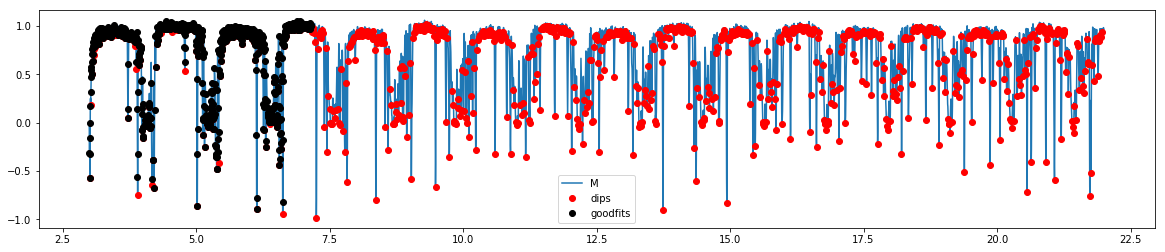

In [23]:
plt.figure(figsize=(20,4))
the_times = 10**6*diamonds[0]['tau']
the_data = diamonds[0]['data']
good_ones = np.array(diamonds[0]['good_fits'])
plt.plot(the_times,the_data,label='M')
plt.plot(the_times[diamonds[0]['dip_inds']],the_data[diamonds[0]['dip_inds']],'ro',label='dips')
plt.plot(the_times[good_ones],the_data[good_ones],'ko',label='goodfits')
plt.legend()
#for ventana in diamonds[0]['windows']:
#    plt.plot(the_times[ventana[0]:ventana[1]],(-0.1)+the_data[ventana[0]:ventana[1]],'r--')
#plt.xlim(15,17.5)
plt.show()

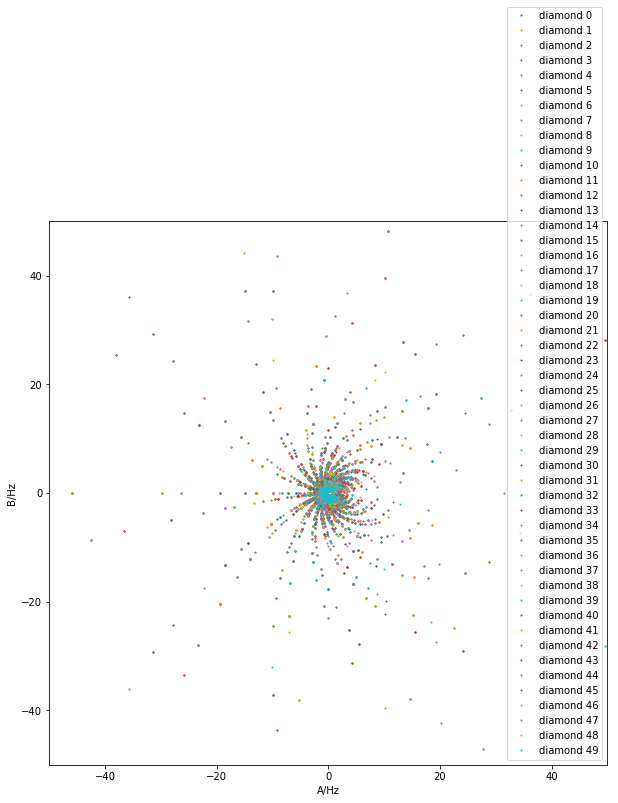

In [11]:
plt.figure(figsize=(10,10))

#plt.subplot(6,5,i+1)
for i in range(50):
    plt.plot(10.**(-3)/2./np.pi*diamonds[i]['A'],10.**(-3)/2./np.pi*diamonds[i]['B'],
             'o',label='diamond '+str(i),ms=1)
plt.xlabel('A/Hz')
plt.ylabel('B/Hz')
plt.legend()
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.show()

In [21]:
import time

In [22]:
time.time()

1494850616.021179

In [55]:
begin_time=time.time()
# What is Michael doing here?
# First he imports two sklearn objects: a scaler and a classifier.
guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
num_correct_list, num_incorrect_list = [], []
As_list, Bs_list = [], []
guess_As_list, guess_Bs_list = [], []
dips_measured = []
# He then iterates through all of the 29 diamonds.
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"] # This is an array with all the free evolution times.
    data = diamond["data"] # These are the corresping M(tau) values for N = 64
    N = diamond["N"]
    dip_inds = diamond["dip_inds"] # indices for the dips in data
    windows = diamond["windows"] # these indices determine the window around each dip
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds))) # only times after 15 micros are taken
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii: # this loop iterates over all dips
        if diamond["good_fits"][dii]: # If this happens to be a good fit then
            dip_ind = dip_inds[dii] 
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features): # this defines a pipeline with scaler and classifier.
        #flip a coin
        the_coin = np.random.rand()
        if the_coin < 0.:
            return np.array([0.])
        else:
            return np.array([1.])
#         return guess_clf.predict(guess_scaler.transform([features]))
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = 1, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct
finish_time = time.time()
print((finish_time-begin_time)/60.)

diamond_ind:  0
dips measured:  388
num_removed:  0
correct:  12 incorrect:  4
diamond_ind:  1
dips measured:  404
num_removed:  2
correct:  16 incorrect:  4
diamond_ind:  2
dips measured:  370
num_removed:  0
correct:  15 incorrect:  4
diamond_ind:  3
dips measured:  382
num_removed:  1
correct:  15 incorrect:  1
diamond_ind:  4
dips measured:  408
num_removed:  2
correct:  9 incorrect:  5
diamond_ind:  5
dips measured:  408
num_removed:  0
correct:  4 incorrect:  10
diamond_ind:  6
dips measured:  420
num_removed:  1
correct:  13 incorrect:  5
diamond_ind:  7
dips measured:  365
num_removed:  0
correct:  12 incorrect:  2
diamond_ind:  8
dips measured:  379
num_removed:  0
correct:  12 incorrect:  5
diamond_ind:  9
dips measured:  373
num_removed:  0
correct:  7 incorrect:  5
diamond_ind:  10
dips measured:  352
num_removed:  3
correct:  17 incorrect:  2
diamond_ind:  11
dips measured:  376
num_removed:  2
correct:  17 incorrect:  3
diamond_ind:  12
dips measured:  455
num_removed:  1

\# defective diamond log and replacements

+ 20 was defective, replaced by 99.
+ 21 is defective too, replaced by 98.
+ 74 is defective too, replaced by 97.
+ 82 is defective too, replaced by 96.

In [23]:
np.mean(num_correct_list), np.mean(num_incorrect_list)

NameError: name 'num_correct_list' is not defined

In [2]:
#results_dict = {"As_list" : As_list, "Bs_list" : Bs_list,
#                "num_correct_list" : num_correct_list, "num_incorrect_list" : num_incorrect_list, "dips_measured" : dips_measured}
#learning.store_obj(results_dict, "results/results_di3220_29diamonds_cxABe_x1")
results_dict = learning.load_obj("results/results_di3220_29diamonds_cxABe_x1")
As_list = results_dict["As_list"]
Bs_list = results_dict["Bs_list"]
num_correct_list = results_dict["num_correct_list"]
num_incorrect_list = results_dict["num_incorrect_list"]
dips_measured = results_dict["dips_measured"]
#print np.mean(results_dict["num_correct_list"])#, num_correct_list
#print results_dict["num_incorrect_list"]#, num_incorrect_list
#As_list = results_dict["As_list"]
#Bs_list = results_dict["Bs_list"]

In [5]:
np.mean(np.array(dips_measured) * 128 + 5100)

55298.068965517239

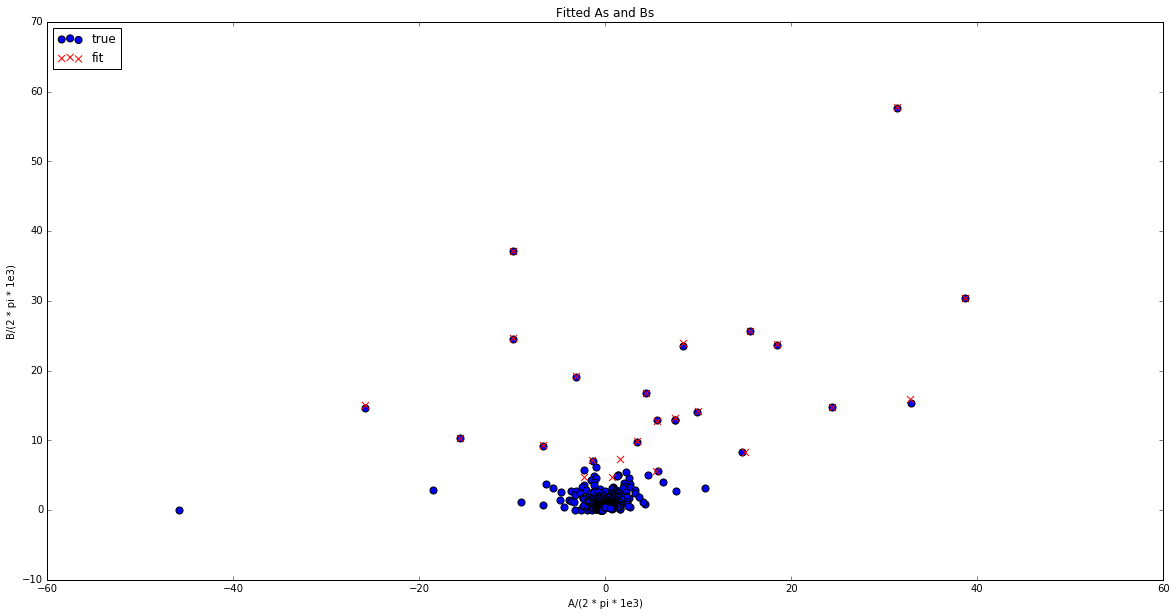

In [83]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(20,10))
plt.title("Fitted As and Bs")
plt.xlabel("A/(2 * pi * 1e3)")
plt.ylabel("B/(2 * pi * 1e3)")
plt.scatter(diamonds[diamond_ind]["A"]/analysis.mag, np.abs(diamonds[diamond_ind]["B"])/analysis.mag, c='b', marker = 'o', s = 50, label = 'true')
plt.scatter(As_list[diamond_ind]/analysis.mag, np.abs(Bs_list[diamond_ind])/analysis.mag, c='r', marker = 'x', s = 50, label = 'fit')
plt.legend(loc=2)
plt.show()

## New Diamonds' Test

In [9]:
# new diamonds 
diamonds=[learning.load_obj("new_diamonds/diamond_1"),
          learning.load_obj("new_diamonds/diamond_2")]

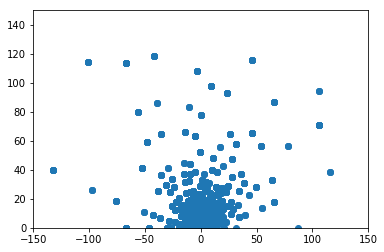

In [74]:
plt.figure()
plt.scatter(full_lattice[:,0]/analysis.mag,full_lattice[:,1]/analysis.mag)
plt.xlim(-150,150)
plt.ylim(0,150)
plt.show()

In [70]:
# What is Michael doing here?
# First he imports two sklearn objects: a scaler and a classifier.
guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
num_correct_list, num_incorrect_list = [], []
As_list, Bs_list = [], []
guess_As_list, guess_Bs_list = [], []
dips_measured = []
####
full_lattice = np.genfromtxt('complete_lattice.csv',delimiter=',');
full_lattice[:,1]=np.abs(full_lattice[:,1])
full_lattice = analysis.mag*full_lattice
dA = 0.5 * analysis.mag
dB = 0.1 * analysis.mag
###

# He then iterates through all of the 29 diamonds.
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"] # This is an array with all the free evolution times.
    data = diamond["data"] # These are the corresping M(tau) values for N = 64
    N = diamond["N"]
    dip_inds = diamond["dip_inds"] # indices for the dips in data
    windows = diamond["windows"] # these indices determine the window around each dip
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds))) # only times after 15 micros are taken
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii: # this loop iterates over all dips
        if diamond["good_fits"][dii]: # If this happens to be a good fit then
            dip_ind = dip_inds[dii] 
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features): # this defines a pipeline with scaler and classifier.
        return guess_clf.predict(guess_scaler.transform([features]))
#     def guess_classifier(features):
#         # to make it compliant to the feature vector defined
#         # by Scheer, I assume that it has five components and only
#         # take the two corresponding to indices 2 and 3
#         # note that dA and dB must be converted to rad / s
#         simple_features = np.array([features[2],features[3]])
#         differences = np.abs(simple_features - full_lattice)
#         if np.any((differences[:,0] < dA) & (differences[:,1] < dB)):
#             return np.array([1.])
#         else:
#             return np.array([0.])
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = 1, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

diamond_ind:  0
dips measured:  388
num_removed:  0
correct:  13 incorrect:  2
diamond_ind:  1
dips measured:  404


KeyboardInterrupt: 

In [93]:
num_incorrect_list

[3, 3]

In [100]:
suffix = "_di3220_29diamonds_cxABe"
guess_set = learning.load_obj("datasets/guess_dataset" + suffix)
xtrain=np.array(guess_set["train_X"])
ytrain=np.array(guess_set["train_Y"])

In [212]:
full_lattice = np.genfromtxt('complete_lattice.csv',delimiter=',');

In [214]:
np.shape(full_lattice)

(33532, 2)

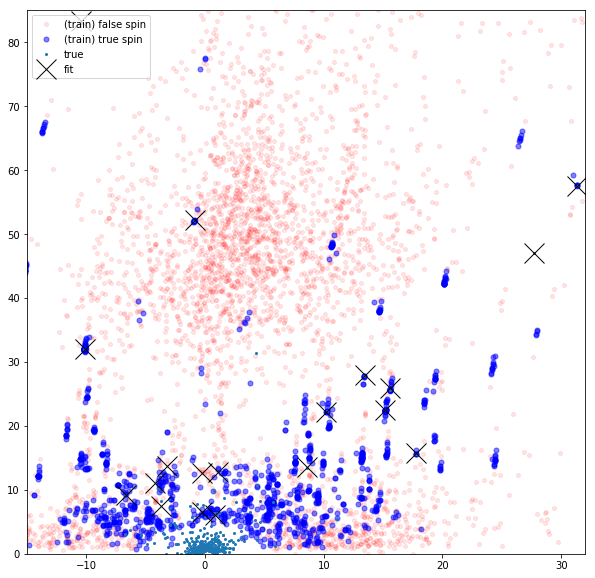

In [223]:
plt.figure(figsize=(10,10))
plt.plot(xtrain[:,2][ytrain==0]/analysis.mag,xtrain[:,3][ytrain==0]/analysis.mag,'ro',label='(train) false spin',ms=4,alpha=0.1)
plt.plot(xtrain[:,2][ytrain==1]/analysis.mag,xtrain[:,3][ytrain==1]/analysis.mag,'bo',label='(train) true spin',ms=5,alpha=0.5)
plt.plot(diamonds[1]['A']/analysis.mag,np.abs(diamonds[1]['B'])/analysis.mag,'o',label='true',ms=2)
plt.plot(As/analysis.mag,Bs/analysis.mag,'kx',ms=20,label='fit')
#plt.plot(lots_of_A/analysis.mag,lots_of_B/analysis.mag,'o',ms=5,label='all_C13',alpha=0.5)
#plt.plot(full_lattice[:,0],np.abs(full_lattice[:,1]),'o',ms=5,label='all_C13',alpha=0.1)
plt.legend()
plt.xlim(-15,32)
plt.ylim(0,85)
plt.show()

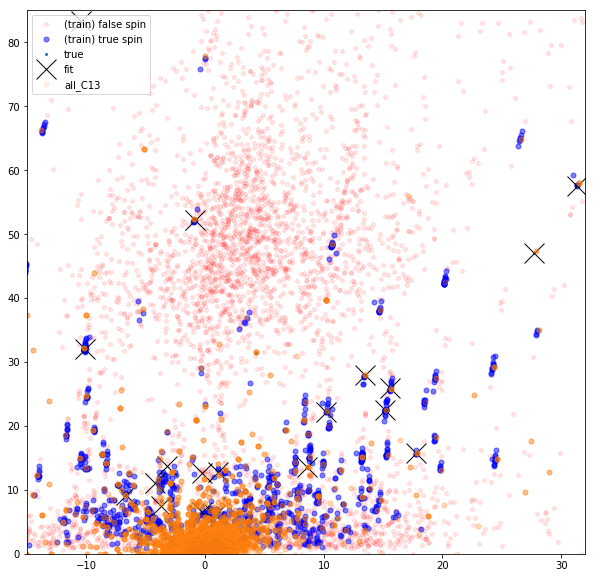

In [222]:
plt.figure(figsize=(10,10))
plt.plot(xtrain[:,2][ytrain==0]/analysis.mag,xtrain[:,3][ytrain==0]/analysis.mag,'ro',label='(train) false spin',ms=4,alpha=0.1)
plt.plot(xtrain[:,2][ytrain==1]/analysis.mag,xtrain[:,3][ytrain==1]/analysis.mag,'bo',label='(train) true spin',ms=5,alpha=0.5)
plt.plot(diamonds[1]['A']/analysis.mag,np.abs(diamonds[1]['B'])/analysis.mag,'o',label='true',ms=2)
plt.plot(As/analysis.mag,Bs/analysis.mag,'kx',ms=20,label='fit')
#plt.plot(lots_of_A/analysis.mag,lots_of_B/analysis.mag,'o',ms=5,label='all_C13',alpha=0.5)
plt.plot(full_lattice[:,0],np.abs(full_lattice[:,1]),'o',ms=5,label='all_C13',alpha=0.1)
plt.legend()
plt.xlim(-15,32)
plt.ylim(0,85)
plt.show()

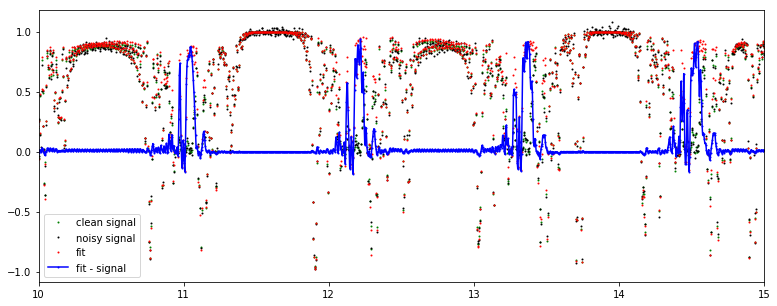

In [87]:
fitted_M = analysis.calc_M(As,Bs,64,omega_larmor,diamonds[1]['tau'])
clean_M = analysis.calc_M(diamonds[1]['A'],diamonds[1]['B'],64,omega_larmor,diamonds[1]['tau'])
plt.figure(figsize=(13,5))
plt.plot(10**6*diamonds[1]['tau'],clean_M,'go',ms=1,label='clean signal')
plt.plot(10**6*diamonds[1]['tau'],diamonds[1]['data'],'ko',ms=1,label='noisy signal')
plt.plot(10**6*diamonds[1]['tau'],fitted_M,'ro',ms=1,label='fit')
plt.plot(10**6*diamonds[1]['tau'],fitted_M - clean_M,'bo-',ms=1,label='fit - signal')
plt.legend()
plt.xlim(10,15)
plt.show()

$\frac{\vec{a}\cdot\vec{b}}{\left|\vec{a}\right| \left|\vec{b}\right|}$

In [76]:
sum(fitted_M*diamonds[1]['data'])/np.sqrt(np.sum(fitted_M**2))/np.sqrt(np.sum(diamonds[1]['data']**2))

0.96875946523919365

In [144]:
many_many=[[],[]]
for i in range(100):
    print(i)
    A,B,_,_,_=NV_generator.generate_spins(450);
    many_many[0].append(A)
    many_many[1].append(B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [145]:
import pickle

In [146]:
#pickle.dump(many_many,open('many_spins.pickle','wb'))

In [199]:
lots_of_A = []
lots_of_B = []
for thisset in many_many[0]:
    for thing in thisset:
        lots_of_A.append(thing);
for thisset in many_many[1]:
    for thing in thisset:
        lots_of_B.append(thing);
lots_of_AB = zip(lots_of_A,lots_of_B)
lots_of_AB = list(set(lots_of_AB))
lots_of_A = np.array(zip(*lots_of_AB)[0])
lots_of_B = np.array(zip(*lots_of_AB)[1])

## Yet another test

In [11]:
# new diamonds 
diamonds=[learning.load_obj("new_diamonds/diamond_1"),
          learning.load_obj("new_diamonds/diamond_2")]

In [15]:
# What is Michael doing here?
# First he imports two sklearn objects: a scaler and a classifier.
guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
num_correct_list, num_incorrect_list = [], []
As_list, Bs_list = [], []
guess_As_list, guess_Bs_list = [], []
dips_measured = []
# He then iterates through all of the 29 diamonds.
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"] # This is an array with all the free evolution times.
    data = diamond["data"] # These are the corresping M(tau) values for N = 64
    N = diamond["N"]
    dip_inds = diamond["dip_inds"] # indices for the dips in data
    windows = diamond["windows"] # these indices determine the window around each dip
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds))) # only times after 15 micros are taken
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii: # this loop iterates over all dips
        if diamond["good_fits"][dii]: # If this happens to be a good fit then
            dip_ind = dip_inds[dii] 
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features): # this defines a pipeline with scaler and classifier.
        #flip a coin
        the_coin = np.random.rand()
        if the_coin < 0.1:
            return np.array([0.])
        else:
            return np.array([1.])
        #return guess_clf.predict(guess_scaler.transform([features]))
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = 1, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

diamond_ind:  0
dips measured:  370
num_removed:  0
correct:  16 incorrect:  4
diamond_ind:  1
dips measured:  372
num_removed:  1
correct:  16 incorrect:  3


## And another with the 29 sets that Michael analyzed

In [37]:
# P(reject) = 0.5
results={}
results0=[0,374,2,18,6,1,429,0,14,5,2,431,0,8,6,3,357,0,13,1,4,426,0,7,1,5,406,0,18,2,6,406,0,12,2,7,375,0,11,2,8,390,0,9,0,9,445,0,14,2,10,388,0,8,0,11,385,0,8,3,12,375,0,7,1,13,402,0,7,1,14,397,0,15,2,15,379,0,12,2,16,372,0,12,2,17,387,0,12,3,18,407,0,17,0,19,401,0,10,6,20,375,0,9,2,21,381,0,20,0,22,433,2,13,2,23,368,0,5,3,24,337,0,11,1,25,405,1,20,6,26,378,0,7,0,27,390,0,10,3,28,374,0,11,2];
results0=zip(results0[::5],results0[1::5],results0[2::5],results0[3::5],results0[4::5])
results['p=0.5']=results0

In [38]:
# "Machine learning"
results0=[0,374,4,19,6,1,429,0,21,4,2,431,0,16,9,3,357,1,14,2,4,426,1,11,2,5,406,1,22,3,6,406,0,14,2,7,375,0,14,1,8,390,0,16,1,9,445,0,18,7,10,388,0,10,0,11,385,0,10,3,12,375,0,9,1,13,402,0,12,1,14,397,0,18,0,15,379,1,13,2,16,372,0,15,3,17,387,0,14,4,18,407,3,22,2,19,401,1,12,4,20,375,1,13,3,21,381,1,23,1,22,433,5,13,4,23,368,0,9,0,24,337,1,12,3,25,405,8,26,7,26,378,0,11,1,27,390,2,15,2,28,374,2,13,1]
results0=zip(results0[::5],results0[1::5],results0[2::5],results0[3::5],results0[4::5])
results['machine learning']=results0

In [62]:
results0=[0,374,2,19,6,1,429,0,22,4,2,431,1,13,8,3,357,1,13,3,4,426,1,10,4,5,406,1,21,4,6,406,0,13,3,7,375,0,9,3,8,390,0,14,2,9,445,0,18,6,10,388,0,10,1,11,385,0,8,6,12,375,0,9,1,13,402,0,11,2,14,397,0,18,0,15,379,1,11,3,16,372,0,15,4,17,387,0,12,5,18,407,3,22,3,19,401,1,11,9,20,375,1,12,6,21,381,2,20,1,22,433,4,13,4,23,368,0,9,3,24,337,1,13,4,25,405,4,21,11,26,378,0,11,1,27,390,2,14,5,28,374,2,13,1]
results0=zip(results0[::5],results0[1::5],results0[2::5],results0[3::5],results0[4::5])
results['p=0.1']=results0

In [69]:
results0=[0,374,4,19,6,1,429,0,21,5,2,431,1,13,10,3,357,2,14,3,4,426,1,11,4,5,406,1,22,3,6,406,0,13,3,7,375,0,9,3,8,390,0,14,2,9,445,0,18,7,10,388,0,10,1,11,385,0,8,7,12,375,0,9,1,13,402,0,12,3,14,397,0,15,1,15,379,1,11,3,16,372,0,15,4,17,387,0,12,6,18,407,3,18,5,19,401,1,11,9,20,375,1,13,6,21,381,2,24,1,22,433,5,13,4,23,368,0,9,3,24,337,1,12,5,25,405,5,20,11,26,378,0,11,1,27,390,2,14,5,28,374,2,13,1]
results0=zip(results0[::5],results0[1::5],results0[2::5],results0[3::5],results0[4::5])
results['p=0.']=results0

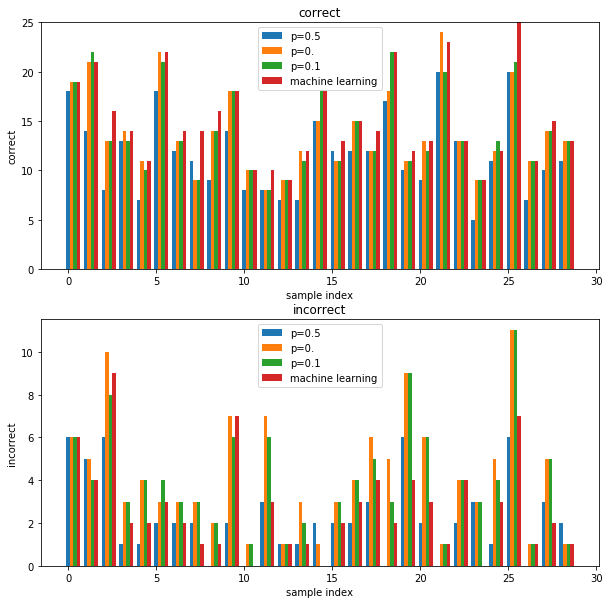

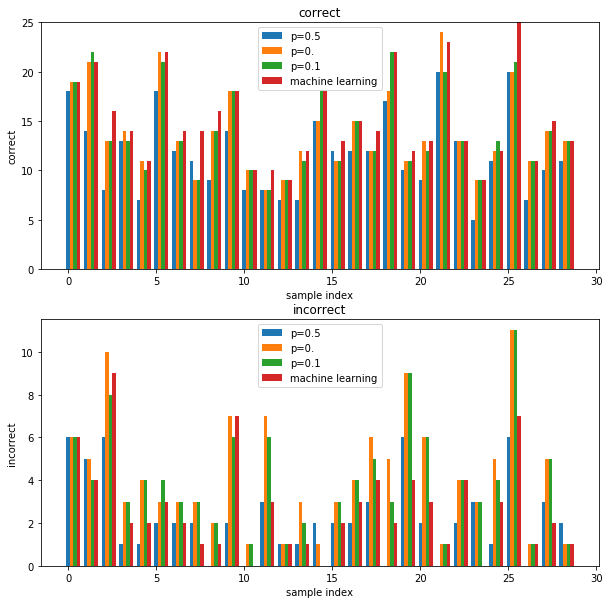

In [91]:
bar_width=0.2
bar_index=0
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for key in results.keys():
    these_results = np.array(map(lambda x: list(x),results[key]))
    xdata = these_results[:,3]
    plt.bar(np.arange(29)+bar_index*bar_width,xdata,bar_width,label=key)
    bar_index+=1
plt.legend()
plt.title('correct')
plt.xlabel('sample index')
plt.ylim(0,25)
plt.ylabel('correct')
plt.subplot(2,1,2)
bar_index=0
for key in results.keys():
    these_results = np.array(map(lambda x: list(x),results[key]))
    xdata = these_results[:,4]
    plt.bar(np.arange(29)+bar_index*bar_width,xdata,bar_width,label=key)
    bar_index+=1
plt.legend()
plt.title('incorrect')
plt.xlabel('sample index')
plt.ylabel('incorrect')
plt.savefig(fig_dir+'bar_charts.png',dpi=200)
plt.savefig(fig_dir+'bar_charts.jpg',dpi=200)
plt.savefig(fig_dir+'bar_charts.pdf')
plt.show()

## And now the same as above but with additional samples, times taken, and statistical analysis

In [19]:
# P(reject) = 0
# time taken: 23.3 minutes
results={}
results0=[0,388,0,12,4,1,404,2,16,4,2,370,0,15,4,3,382,1,15,1,4,408,2,9,5,5,408,0,4,10,6,420,1,13,5,7,365,0,12,2,8,379,0,12,5,9,373,0,7,5,10,352,3,17,2,11,376,2,17,3,12,455,1,17,11,13,408,0,13,6,14,349,0,14,3,15,388,0,11,4,16,389,4,19,4,17,382,2,14,1,18,425,1,17,4,19,433,4,17,5,20,429,0,19,6,21,382,2,15,5,22,405,0,11,1,23,383,1,9,3,24,354,0,13,4,25,372,0,21,3,26,420,4,16,5,27,407,0,13,9,28,415,1,13,5,29,390,2,13,6,30,383,0,17,7,31,413,2,20,6,32,387,1,16,5,33,365,4,11,7,34,377,0,14,2,35,355,1,9,4,36,390,1,12,3,37,438,2,19,6,38,407,2,13,4,39,400,1,12,3,40,423,0,4,3,41,424,0,14,10,42,360,3,16,3,43,401,1,13,5,44,397,0,8,2,45,372,1,8,0,46,426,3,15,5,47,356,1,14,1,48,400,0,9,1,49,419,0,10,5,50,450,2,20,10,51,396,3,15,3,52,372,3,12,6,53,417,1,10,5,54,398,2,18,5,55,375,3,12,4,56,366,0,17,9,57,389,1,9,5,58,409,3,20,8,59,416,2,21,2,60,380,1,14,4,61,368,2,11,7,62,414,0,8,4,63,350,0,13,3,64,389,1,9,3,65,382,2,13,2,66,373,2,9,2,67,385,0,17,2,68,423,0,9,6,69,374,1,10,4,70,385,2,11,6,71,389,0,7,2,72,410,0,21,1,73,394,0,13,3,74,379,3,6,4,75,377,0,16,3,76,389,2,12,2,77,342,3,20,1,78,435,2,13,5,79,369,2,13,10,80,386,3,14,3,81,392,0,8,2,82,416,4,26,9,83,419,0,11,9,84,406,1,13,6,85,385,0,9,2,86,414,1,13,3,87,415,3,13,11,88,396,0,12,6,89,370,0,12,5,90,380,0,4,4,91,402,2,15,2,92,419,0,13,3,93,404,0,12,8,94,432,6,22,10,95,345,2,15,7];
results0=zip(results0[::5],results0[1::5],results0[2::5],results0[3::5],results0[4::5])
results['p=0']=results0

In [27]:
# "Machine learning"
# time taken: 20.9 minutes
results0=[0,388,0,13,2,1,404,1,16,3,2,370,0,17,1,3,382,1,15,1,4,408,1,10,4,5,408,0,4,3,6,420,1,13,5,7,365,0,12,2,8,379,0,13,3,9,373,0,7,2,10,352,0,17,2,11,376,1,19,3,12,455,1,24,5,13,408,0,14,5,14,349,0,15,1,15,388,0,11,2,16,389,4,19,3,17,382,2,14,1,18,425,1,18,3,19,433,4,17,4,20,429,1,21,3,21,382,1,15,4,22,405,0,11,0,23,383,1,9,1,24,354,0,13,3,25,372,0,21,3,26,420,3,20,3,27,407,0,13,9,28,415,1,14,1,29,390,1,15,7,30,383,0,19,0,31,413,2,23,4,32,387,1,16,4,33,365,2,12,6,34,377,0,14,2,35,355,1,10,2,36,390,1,12,1,37,438,2,19,6,38,407,1,13,3,39,400,1,12,2,40,423,0,5,1,41,424,0,15,6,42,360,2,16,2,43,401,1,13,4,44,397,0,7,1,45,372,1,8,0,46,426,2,15,3,47,356,1,14,1,48,400,0,9,1,49,419,0,10,4,50,450,2,21,9,51,396,3,15,2,52,372,1,12,3,53,417,1,10,5,54,398,2,18,4,55,375,0,13,4,56,366,0,18,9,57,389,0,12,2,58,409,2,22,5,59,416,0,22,3,60,380,0,15,2,61,368,2,12,4,62,414,0,10,2,63,350,0,15,2,64,389,1,9,1,65,382,2,15,1,66,373,2,8,0,67,385,0,16,1,68,423,0,9,6,69,374,0,10,0,70,385,2,13,5,71,389,0,7,1,72,410,0,21,0,73,394,0,13,3,74,379,2,11,2,75,377,0,16,2,76,389,1,13,1,77,342,3,20,1,78,435,2,13,4,79,369,3,18,8,80,386,0,16,1,81,392,0,8,1,82,416,3,28,7,83,419,0,13,6,84,406,1,16,1,85,385,0,9,2,86,414,1,13,1,87,415,2,16,7,88,396,0,12,6,89,370,0,14,3,90,380,0,4,2,91,402,3,12,4,92,419,0,13,0,93,404,0,12,4,94,432,10,25,7,95,345,3,22,2]
results0=zip(results0[::5],results0[1::5],results0[2::5],results0[3::5],results0[4::5])
results['machine learning']=results0

In [43]:
for llave in results.keys():
    print(llave)
    # correct average
    print(np.mean(np.array(results[llave])[:,-2]))
# incorrect average
    print(np.mean(np.array(results[llave])[:,-1]))

p=0
13.3229166667
4.5625
machine learning
14.1875
3.0


In [53]:
# corrects
print("svc > p=0",np.sum(np.array(results['machine learning'])[:,-2] > np.array(results['p=0'])[:,-2]))
print("svc = p=0",np.sum(np.array(results['machine learning'])[:,-2] == np.array(results['p=0'])[:,-2]))
print("svc < p=0",np.sum(np.array(results['machine learning'])[:,-2] < np.array(results['p=0'])[:,-2]))

('svc > p=0', 42)
('svc = p=0', 50)
('svc < p=0', 4)


In [54]:
# incorrects
print("svc > p=0",np.sum(np.array(results['machine learning'])[:,-1] > np.array(results['p=0'])[:,-1]))
print("svc = p=0",np.sum(np.array(results['machine learning'])[:,-1] == np.array(results['p=0'])[:,-1]))
print("svc < p=0",np.sum(np.array(results['machine learning'])[:,-1] < np.array(results['p=0'])[:,-1]))

('svc > p=0', 3)
('svc = p=0', 21)
('svc < p=0', 72)


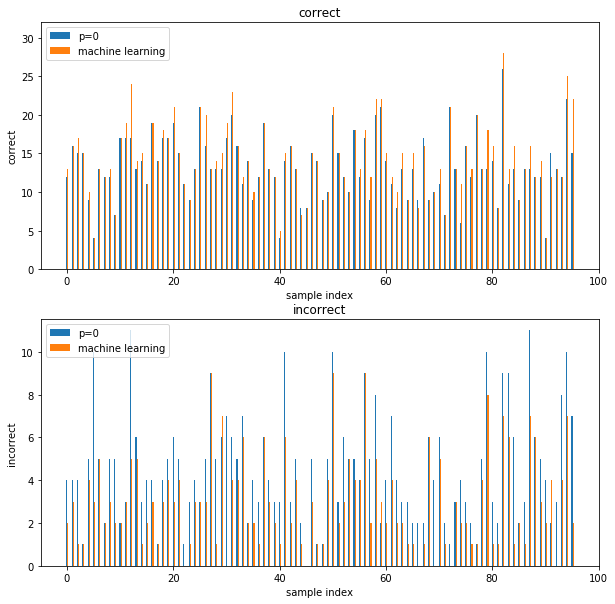

In [31]:
bar_width=0.2
bar_index=0
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for key in results.keys():
    these_results = np.array(map(lambda x: list(x),results[key]))
    xdata = these_results[:,3]
    plt.bar(np.arange(len(these_results))+bar_index*bar_width,xdata,bar_width,label=key)
    bar_index+=1
plt.legend()
plt.title('correct')
plt.xlabel('sample index')
plt.ylim(0,32)
plt.ylabel('correct')
plt.subplot(2,1,2)
bar_index=0
for key in results.keys():
    these_results = np.array(map(lambda x: list(x),results[key]))
    xdata = these_results[:,4]
    plt.bar(np.arange(len(these_results))+bar_index*bar_width,xdata,bar_width,label=key)
    bar_index+=1
plt.legend()
plt.title('incorrect')
plt.xlabel('sample index')
plt.ylabel('incorrect')
#plt.savefig(fig_dir+'bar_charts.png',dpi=200)
#plt.savefig(fig_dir+'bar_charts.jpg',dpi=200)
#plt.savefig(fig_dir+'bar_charts.pdf')
plt.show()

I will now test a simpler filter

In [67]:
def simple_filter(features,all_lattice,dA,dB):
    # to make it compliant to the feature vector defined
    # by Scheer, I assume that it has five components and only
    # take the two corresponding to indices 2 and 3
    # note that dA and dB must be converted to rad / s
    simple_features = np.array([features[2],features[3]])
    differences = np.abs(simple_features - all_lattice)
    if np.any((differences[:,0] < dA) & (differences[:,1] < dB)):
        return np.array([1.])
    else:
        return np.array([0.])

In [57]:
full_lattice = np.genfromtxt('complete_lattice.csv',delimiter=',');

In [63]:
0.5*analysis.mag

3141.592653589793

In [68]:
simple_filter(np.array([100,100,10**8,100,100]), full_lattice, 0.1*analysis.mag, 0.5*analysis.mag)

array([ 0.])

## Testing the individual results

In [93]:
# new diamonds 
diamonds=[learning.load_obj("diamonds/diamond_1")]

In [ ]:
analysis.calc_M()

In [144]:
omega_larmor

-2714391.6410000003

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(10**6*diamonds[0]['tau'],analysis.calc_M([],diamonds[0]['B'],64,omega_larmor,diamonds[0]['tau']))
plt.plot(10**6*diamonds[0]['tau'],diamonds[0]['data'],label='with added noise')
plt.xlim(10,12.5)
plt.legend()
plt.show()

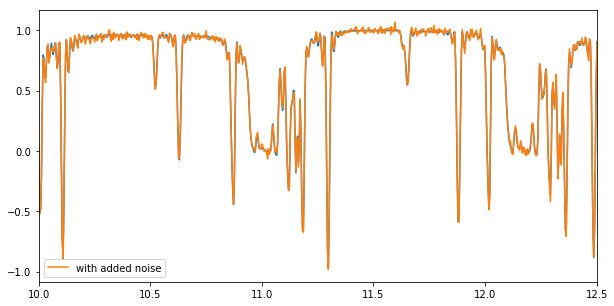

In [141]:
plt.figure(figsize=(10,5))
plt.plot(10**6*diamonds[0]['tau'],analysis.calc_M(diamonds[0]['A'],diamonds[0]['B'],64,omega_larmor,diamonds[0]['tau']))
plt.plot(10**6*diamonds[0]['tau'],diamonds[0]['data'],label='with added noise')
plt.xlim(10,12.5)
plt.legend()
plt.show()

In [147]:
max(diamonds[0]['tau'])

2.1999999999999999e-05

In [158]:
# This to take data into Mathematica
packet_tm=zip(diamonds[0]['tau'],diamonds[0]['data'])
np.savetxt('packet_tm.csv',packet_tm,delimiter=",")
packet_AB=zip(diamonds[0]['A'],diamonds[0]['B'])
np.savetxt('packet_AB.csv',packet_AB,delimiter=",")

In [124]:
diamonds[0].keys()

['A',
 'tau',
 'B',
 'successful_fits',
 'windows',
 'data',
 'N_data',
 'error_tol',
 'N',
 'N_vals',
 'num_subsets',
 'xs_list',
 'costheta',
 'scaled_errors',
 'phis_list',
 'r',
 'dip_inds',
 'sintheta',
 'good_fits']

In [94]:
measured = []
# He then iterates through all of the 29 diamonds.
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"] # This is an array with all the free evolution times.
    data = diamond["data"] # These are the corresping M(tau) values for N = 64
    N = diamond["N"]
    dip_inds = diamond["dip_inds"] # indices for the dips in data
    windows = diamond["windows"] # these indices determine the window around each dip
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds))) # only times after 15 micros are taken
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii: # this loop iterates over all dips
        if diamond["good_fits"][dii]: # If this happens to be a good fit then
            dip_ind = dip_inds[dii] 
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features): # this defines a pipeline with scaler and classifier.
        return guess_clf.predict(guess_scaler.transform([features]))
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = 1, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

diamond_ind:  0
dips measured:  429
num_removed:  0
correct:  21 incorrect:  4


In [100]:
two_As={}

In [101]:
two_As['ML']=[As,Bs]

In [103]:
measured = []
# He then iterates through all of the 29 diamonds.
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"] # This is an array with all the free evolution times.
    data = diamond["data"] # These are the corresping M(tau) values for N = 64
    N = diamond["N"]
    dip_inds = diamond["dip_inds"] # indices for the dips in data
    windows = diamond["windows"] # these indices determine the window around each dip
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds))) # only times after 15 micros are taken
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii: # this loop iterates over all dips
        if diamond["good_fits"][dii]: # If this happens to be a good fit then
            dip_ind = dip_inds[dii] 
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features): # this defines a pipeline with scaler and classifier.
        return np.array([1.0])
        #return guess_clf.predict(guess_scaler.transform([features]))
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = 1, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

diamond_ind:  0
dips measured:  429
num_removed:  0
correct:  21 incorrect:  5


In [104]:
two_As['All']=[As,Bs]

In [116]:
two_As['All'][0]

array([ -2.38987348e+05,   3.41023656e+04,  -1.30465267e+01,
         3.49043371e+04,   9.54297173e+04,   1.83865650e+04,
        -1.71046793e+04,   6.98492357e+04,  -3.49755316e+04,
         1.35250400e+03,   4.07317227e+05,   8.27638371e+04,
         3.39962021e+04,   8.43656436e+04,   6.43394305e+04,
         3.60196521e+04,  -5.87689033e+04,   1.56581408e+04,
         4.83515283e+04,   1.26738726e+04,   3.12131786e+05,
        -6.78407062e+05,   3.47860872e+04,   1.52312121e+05,
        -1.61135837e+04,   1.91340149e+04])

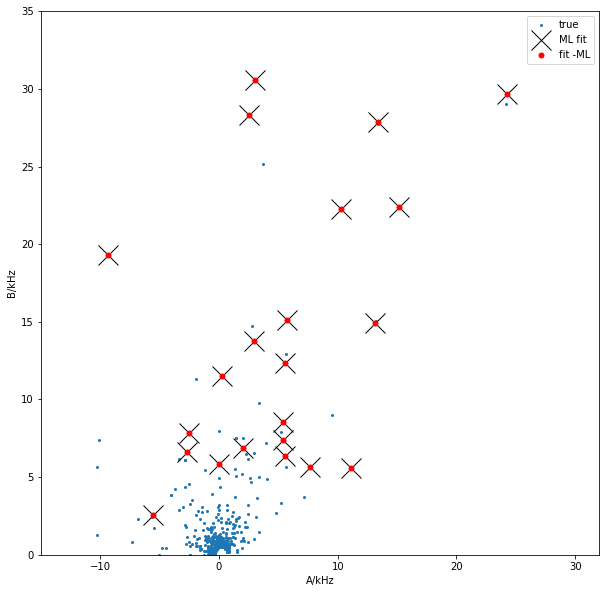

In [114]:
plt.figure(figsize=(10,10))
#plt.plot(xtrain[:,2][ytrain==0]/analysis.mag,xtrain[:,3][ytrain==0]/analysis.mag,'ro',label='(train) false spin',ms=4,alpha=0.1)
#plt.plot(xtrain[:,2][ytrain==1]/analysis.mag,xtrain[:,3][ytrain==1]/analysis.mag,'bo',label='(train) true spin',ms=5,alpha=0.5)
plt.plot(diamonds[0]['A']/analysis.mag,np.abs(diamonds[0]['B'])/analysis.mag,'o',label='true',ms=2)
plt.plot(two_As['ML'][0]/analysis.mag,two_As['ML'][1]/analysis.mag,'kx',ms=20,label='ML fit')
plt.plot(two_As['All'][0]/analysis.mag,two_As['All'][1]/analysis.mag,'ro',ms=5,label='fit -ML')
#plt.plot(lots_of_A/analysis.mag,lots_of_B/analysis.mag,'o',ms=5,label='all_C13',alpha=0.5)
#plt.plot(full_lattice[:,0],np.abs(full_lattice[:,1]),'o',ms=5,label='all_C13',alpha=0.1)
plt.legend()
plt.xlim(-15,32)
plt.ylim(0,35)
plt.xlabel('A/kHz')
plt.ylabel('B/kHz')
plt.savefig(fig_dir+'all_spins_comparison.jpg',dpi=300)
plt.savefig(fig_dir+'all_spins_comparison.png',dpi=300)
plt.savefig(fig_dir+'all_spins_comparison.pdf')
plt.show()

In [120]:
import pickle

In [121]:
pickle.dump(two_As,open('two_As.pickle','wb'))